# Import Modules
This section imports the required modules and prepare the raw content of the file in the desired
data type for performance

In [1]:
import re
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from zipfile import ZipFile
from wordcloud import WordCloud
from pandas.api.types import CategoricalDtype

### Read file

In [2]:
# Read csv file ziped
zip_path = './data/human-trafficking-victims-dataset-ctdc.zip'
data_file = None
raw_data = None
with ZipFile(zip_path) as zip_file:
    for commpresed in zip_file.filelist:
        if commpresed.filename.endswith('csv'):
            with zip_file.open(commpresed) as data_file:
                raw_data = pd.read_csv(
                    data_file,
                    sep=';',
                    header=0,
                    low_memory=False,
                    usecols=range(1,64),)

### Data type convertion

In [3]:
# Setting values of categorical attribute
# for performnce at processing time
# Age numerical categories
age_range = [
    '0--8',
    '9--17',
    '18--20',
    '21--23',
    '24--26',
    '27--29',
    '30--38',
    '39--47',
    '48+'
]
# Gender categories
gender_values = [
    'Male',
    'Female',
    'Transgender/NonConforming',
]
# Age status categories
age_cate = [
    'Adult',
    'Minor',
]
# Data recorders categories
data_source = [
    'Case Management',
    'Hotline'
]
# Categorical pandas objects
age_cat_range = CategoricalDtype(categories=age_range, ordered=True)
gender_cat = CategoricalDtype(categories=gender_values, ordered=False)
age_cat = CategoricalDtype(categories=age_cate, ordered=True)
data_cat_source = CategoricalDtype(categories=data_source, ordered=False)

In [4]:
# Convert all values read as float due to NaN
raw_data = raw_data.apply(lambda serie: serie.astype('Int32', errors='ignore'))
# Converto to categorical types
raw_data['Datasource'] = raw_data['Datasource'].astype(data_cat_source)
raw_data['gender'] = raw_data['gender'].astype(gender_cat)
raw_data['ageBroad'] = raw_data['ageBroad'].astype(age_cat_range)

columns_age_cat = ['majorityStatus', 'majorityStatusAtExploit', 'majorityEntry']
raw_data[columns_age_cat] = raw_data[columns_age_cat].astype(age_cat)

### Others objects

In [5]:
# Object to perform the word cloud plot
word_cloud = WordCloud(
    contour_color='black',
    collocations=False,
    mode='RGB',
    background_color='white',
    colormap='RdYlBu')

# Categorical objects attributes
categorical_columns = [
    'ageBroad',
    'Datasource',
    'gender',
    'majorityStatus',
    'majorityStatusAtExploit',
    'majorityEntry']

# Categorical countries
country_columns = [
    'citizenship',
    'CountryOfExploitation']

# Method to convert country ISO2 to ISO numeric code
def country_code(country):
    try:
        return pycountry.countries.lookup(country).numeric
    except LookupError:
        # It is a missing data and cannot be convert 'NaN'
        # value of contry to numeric code
        return -1 

# Descriptive analysis



### Data presentation

In [125]:
raw_data

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,<NA>,<NA>,...,<NA>,NaN,0,NaN,NaN,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,<NA>,<NA>,...,<NA>,NaN,0,NaN,NaN,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,<NA>,<NA>,...,<NA>,NaN,0,NaN,NaN,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,<NA>,<NA>,...,<NA>,NaN,0,NaN,NaN,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,<NA>,<NA>,...,<NA>,NaN,0,NaN,NaN,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97745,<NA>,Case Management,Male,9--17,Minor,NaN,NaN,CM,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,LY,0,0,0,0,1
97746,<NA>,Case Management,Male,9--17,Minor,NaN,NaN,CM,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,LY,0,0,0,0,1
97747,<NA>,Case Management,Male,9--17,Minor,NaN,NaN,CM,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,LY,0,0,0,0,1
97748,<NA>,Case Management,Male,9--17,Minor,NaN,NaN,CM,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,LY,0,0,0,0,1


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97750 entries, 0 to 97749
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   yearOfRegistration                      95739 non-null  Int32   
 1   Datasource                              97750 non-null  category
 2   gender                                  89612 non-null  category
 3   ageBroad                                50967 non-null  category
 4   majorityStatus                          71246 non-null  category
 5   majorityStatusAtExploit                 21286 non-null  category
 6   majorityEntry                           7252 non-null   category
 7   citizenship                             53290 non-null  object  
 8   meansOfControlDebtBondage               8235 non-null   Int32   
 9   meansOfControlTakesEarnings             11438 non-null  Int32   
 10  meansOfControlRestrictsFinancialAccess  4331 n

In [7]:
print(f'The data-set has a total of records and atributes {raw_data.shape}\n')
print('Count total of data types in data-set')
unique_types = raw_data.dtypes.value_counts()
print(unique_types.to_string())

The data-set has a total of records and atributes (97750, 63)

Count total of data types in data-set
Int32       50
object       7
category     3
category     1
category     1
category     1


In [8]:
# NaN values per record in data-set
nan_record = raw_data.isna().sum(axis=1).describe()
print('Misising "NaN" attributes per record')
print(nan_record.to_string(header=True))

Misising "NaN" attributes per record
count    97750.000000
mean        36.001146
std         11.850157
min          1.000000
25%         28.000000
50%         35.000000
75%         50.000000
max         56.000000


In [9]:
# NaN values per attribute in data-set
nan_attribute = raw_data.isna().sum()
ratio_nan = nan_attribute / raw_data.shape[0]
print('Ratio of missing values in attributes', ratio_nan.to_string(), sep='\n')

Ratio of missing values in attributes
yearOfRegistration                        0.020573
Datasource                                0.000000
gender                                    0.083253
ageBroad                                  0.478598
majorityStatus                            0.271141
majorityStatusAtExploit                   0.782240
majorityEntry                             0.925811
citizenship                               0.454834
meansOfControlDebtBondage                 0.915754
meansOfControlTakesEarnings               0.882987
meansOfControlRestrictsFinancialAccess    0.955693
meansOfControlThreats                     0.841156
meansOfControlPsychologicalAbuse          0.849248
meansOfControlPhysicalAbuse               0.877923
meansOfControlSexualAbuse                 0.907795
meansOfControlFalsePromises               0.916890
meansOfControlPsychoactiveSubstances      0.887754
meansOfControlRestrictsMovement           0.855621
meansOfControlRestrictsMedicalCare        0.

In [10]:
duplicates = raw_data.duplicated().sum()
ration_dup = duplicates / raw_data.shape[0]
print(f'Total of elements duplicateds: {duplicates}\nRatio of all data-set: {ration_dup:.2%}')

Total of elements duplicateds: 77084
Ratio of all data-set: 78.86%


**Si bien los datos son duplicados, hay que recordar que son datos anonimizados, cada uno es una lectura de una victima de trata de humanos**

### Descriptive stats data type

There are two type of attributes in the data set, _nominal_ and _numeric_.
The _numeric_ attributes are mostly _ordinal_ binary used to indicat if the attribute is present in a record, by the other side, _nominal_ attributes where converted to a __Categorical__ data type of the package of _pandas_

In [11]:
# Numeric attributes description
raw_data.describe(exclude=['category', 'O'])

,yearOfRegistration,meansOfControlDebtBondage,meansOfControlTakesEarnings,meansOfControlRestrictsFinancialAccess,meansOfControlThreats,meansOfControlPsychologicalAbuse,meansOfControlPhysicalAbuse,meansOfControlSexualAbuse,meansOfControlFalsePromises,meansOfControlPsychoactiveSubstances,...,typeOfSexProstitution,typeOfSexPornography,typeOfSexRemoteInteractiveServices,typeOfSexPrivateSexualServices,isAbduction,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
count,95739.0,8235.0,11438.0,4331.0,15527.0,14736.0,11933.0,9013.0,8124.0,10972.0,...,39662.0,30732.0,30732.0,29167.0,30422.0,57963.0,57963.0,57963.0,57963.0,97514.0
mean,2015.961186,0.493625,0.773999,0.133456,0.815161,0.835573,0.71097,0.463553,0.76034,0.553409,...,0.335006,0.060718,0.00384,0.016697,0.011965,0.062178,0.054069,0.05714,0.173663,0.797732
std,3.776725,0.49999,0.418258,0.340107,0.38818,0.370675,0.453331,0.498697,0.426902,0.497162,...,0.471998,0.238817,0.061847,0.128136,0.10873,0.24148,0.226156,0.232112,0.378822,0.401693
min,2002.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2015.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50%,2017.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,2018.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,2021.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
# Nominal attributes
raw_data.describe(include=['category'])

,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry
count,97750,89612,50967,71246,21286,7252
unique,2,3,9,2,2,2
top,Hotline,Female,9--17,Adult,Minor,Adult
freq,52607,68083,12507,51596,14253,5820


### Plots
Graphical description of the attributes and the relations between each other, the plot used to describe the data are _bar_, _word cloud_, _scatter_, _box_.
The objetive is observe potential trends, frecuencies and relationships.

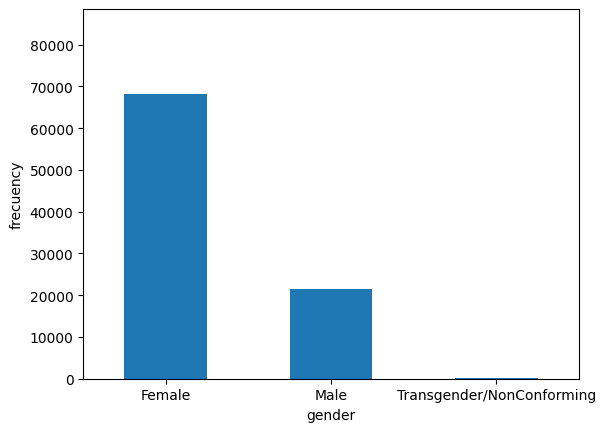

In [13]:
# Gender of the individuals
plot = raw_data['gender'].value_counts().plot.bar(ylabel='frecuency', xlabel='gender')
labels = [label.set_rotation('horizontal') for label in plot.get_xticklabels()]
plot.margins(x=0, y=0.3)

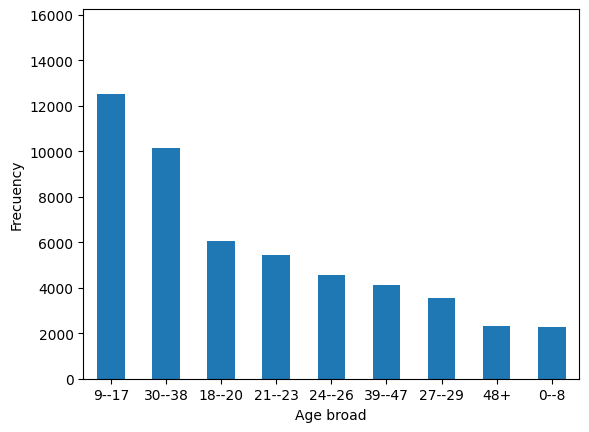

In [14]:
# Histogram of the age of the individual
age_count = raw_data['ageBroad'].value_counts()
plot = raw_data['ageBroad'].value_counts().plot.bar(xlabel="Age broad", ylabel="Frecuency")
labels = [label.set_rotation('horizontal') for label in plot.get_xticklabels()]
for bar, count in zip(plot.patches, age_count):
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 300,
        f"{count}",
        horizontalalignment='center', verticalalignment='bottom',
        fontsize=10, rotation=45, color='white')
plot.margins(x=0, y=0.3)

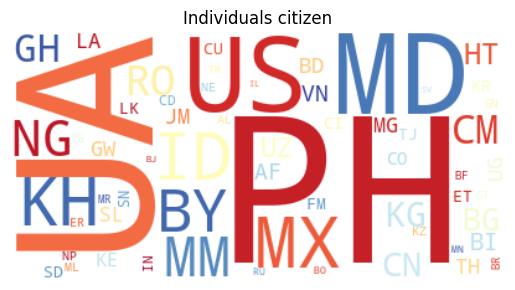

In [15]:
# Word cloud of the individual citizen
citizen = raw_data['citizenship'].dropna().value_counts()

word_image = word_cloud.generate_from_frequencies(citizen)
plt.imshow(word_cloud, interpolation='bilinear',)
plt.title('Individuals citizen')
plt.axis('off')
plt.show()

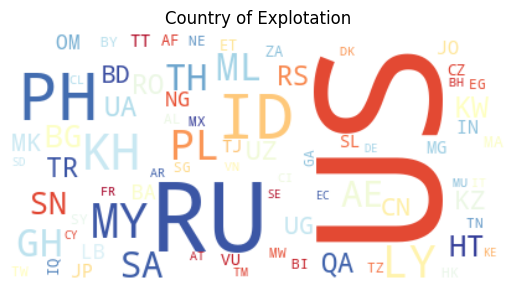

In [16]:
# Word cloud of the country where the individual were exploited
country_exploit = raw_data['CountryOfExploitation'].dropna().value_counts()

word_image = word_cloud.generate_from_frequencies(country_exploit)
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Country of Explotation')
plt.axis('off')
plt.show()

In [17]:
count_totals = raw_data.filter(regex='(Concatenated|Relationship)$')
count_totals = count_totals.applymap(lambda x: len(x.split(';')), na_action='ignore').fillna(0).astype('int32')
count_totals.rename(columns=lambda x: re.sub(r'(Concatenated)?$', 'Count', x, count=1), inplace=True)

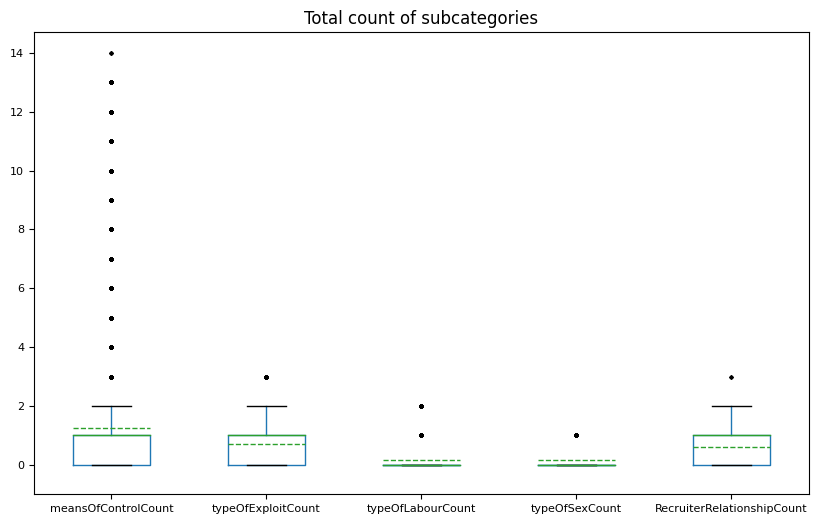

In [116]:
axis = count_totals.boxplot(
    fontsize=8,
    grid=False,
    figsize=(10, 6),
    showcaps=True,
    flierprops={'marker': '.', 'markersize': 3},
    showmeans=True,
    meanline=True,)
    # whis=(0, 98.54))
axis.set_ylim(-1)
title = axis.set_title('Total count of subcategories')

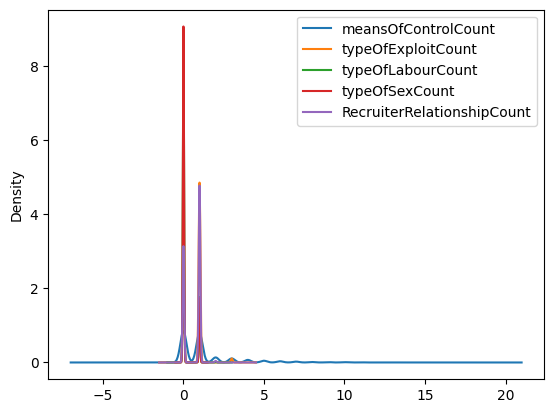

In [123]:
axis = count_totals.plot.kde()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


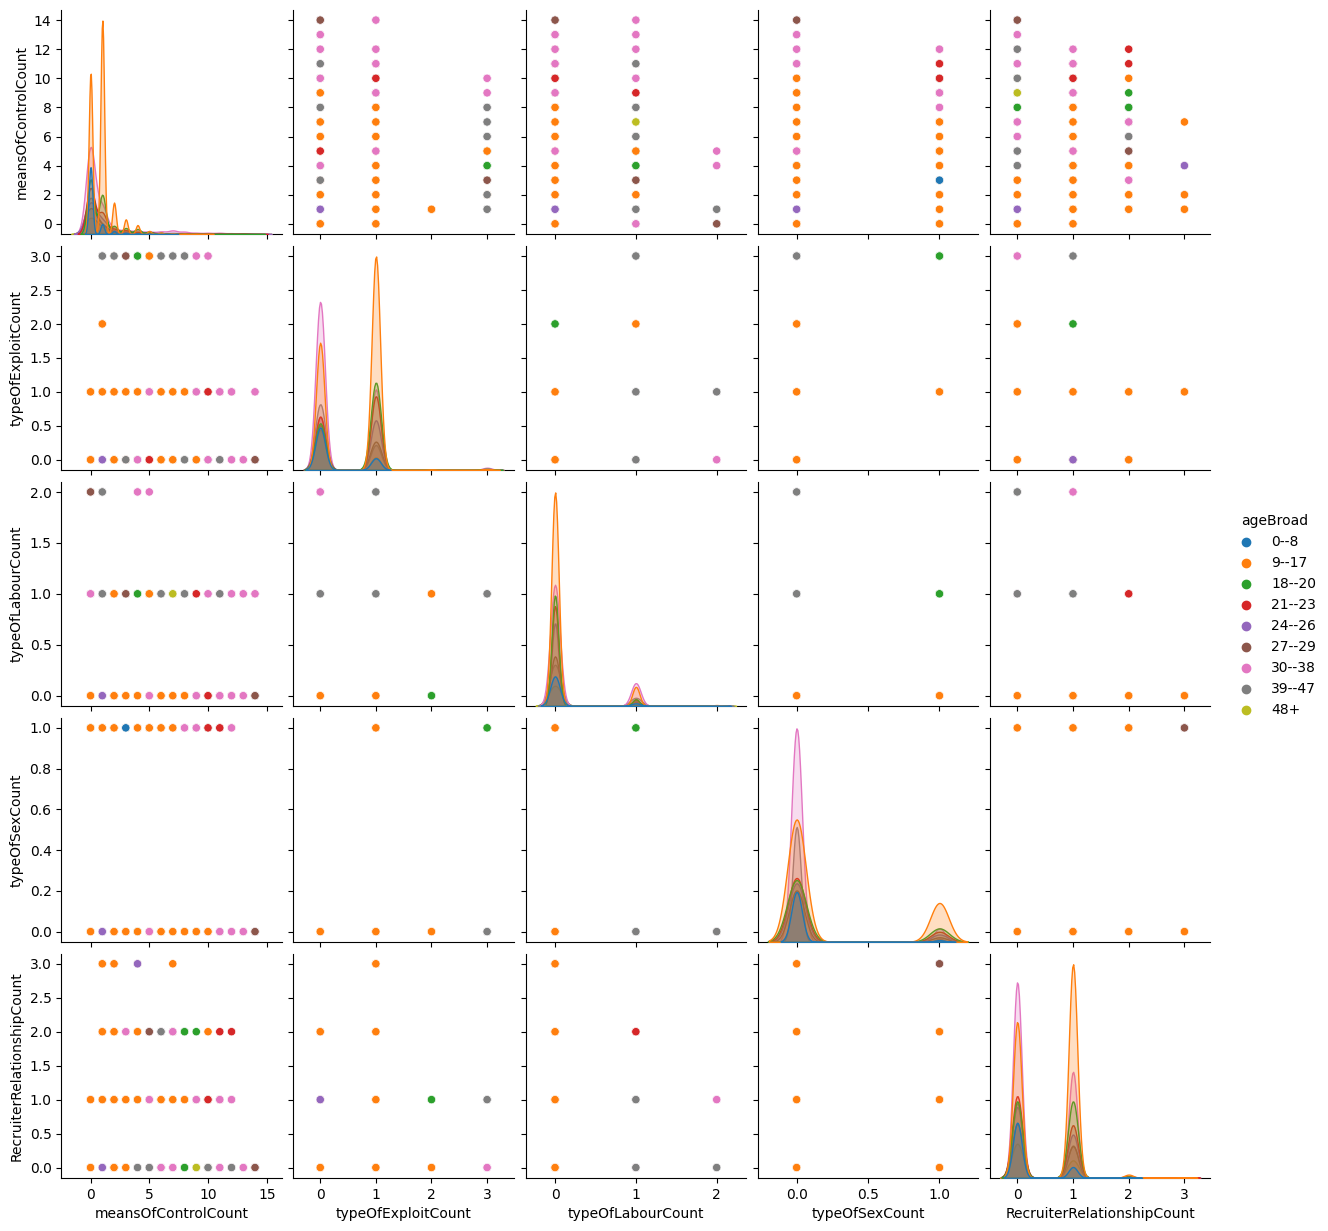

In [130]:
import seaborn as sns
test = pd.concat([count_totals, raw_data.select_dtypes('category')], axis=1)
test['ageBroad']
g = sns.pairplot(test, hue='ageBroad')

### Other thing

In [19]:
# Change categorical data type from string to encoder number
raw_data['citizenship'].map(country_code).head()
raw_data['CountryOfExploitation'].map(country_code)

0         -1
1         -1
2         -1
3         -1
4         -1
        ... 
97745    434
97746    434
97747    434
97748    434
97749    434
Name: CountryOfExploitation, Length: 97750, dtype: object